# Piecewise Regression

In [1]:
from tqdm import tqdm
import torch
from torch.distributions import constraints

import pyro
from pyro.distributions import *
from pyro.infer import SVI, Trace_ELBO

from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.autoguide.initialization import init_to_sample

import matplotlib.pyplot as plt
import copy

In [2]:
pyro.set_rng_seed(0)

### Synthetic data

Let's generate some piecewise linear data.

In [3]:
n_pieces = 5
N = 700
x = torch.rand(N).sort()[0]*100
slopes = Uniform(-3,3).sample([n_pieces])
knots,_ = Uniform(0,N).sample([n_pieces-1]).sort()
knots = knots.long()
intercepts = [Uniform(-10,10).sample()]
y_noise = 3.

In [4]:
y = []
prev_knot = 0
for i,knot in enumerate(knots):
    y.append(Normal(slopes[i]*x[prev_knot:knot]+intercepts[i],y_noise).sample())
    intercepts.append(slopes[i]*x[knot]+intercepts[i] - slopes[i+1]*x[knot])
    prev_knot = knot
y.append(Normal(slopes[-1]*x[knots[-1]:]+intercepts[-1],y_noise).sample())
y = torch.cat(y)

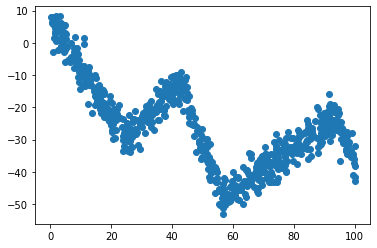

In [5]:
plt.scatter(x,y)

### Model

In [6]:
def piecewise_eval(knot_x, knot_y, x):
    n_knots = knot_x.size(-1)
    assert n_knots >= 2
    knot_x, idx = knot_x.sort(dim=-1)
    knot_y = knot_y.gather(-1,idx)
    lb = (x.unsqueeze(-1) > knot_x[...,1:].unsqueeze(-2)).long().sum(-1)
    lb[lb >= n_knots - 1] = n_knots - 2
    ub = lb + 1
    x0 = knot_x.gather(-1,lb)
    x1 = knot_x.gather(-1,ub)
    y0 = knot_y.gather(-1,lb)
    y1 = knot_y.gather(-1,ub)
    slopes = (y1-y0)/(x1-x0).clamp(min=1e-8)
    return slopes*x + (y1 - slopes*x1)

In [7]:
def piecewise_regression(x, y, n_knots=3):
    x_knot_prior = Uniform(0, 1)
    knot_x = pyro.sample("knot_x",
                         x_knot_prior
                             .expand([n_knots-2]).to_event(0))
    knot_y = pyro.sample("knot_y",
                         Normal(0, 1)
                             .expand([n_knots]).to_event(0))
    knot_shape = knot_x.shape[:-1] + (1,)
    knot_x = torch.cat([torch.zeros(knot_shape), knot_x, torch.ones(knot_shape)], dim=-1)
    x_len = x.max()-x.min()
    y_pred = piecewise_eval(x_len*knot_x, x_len*knot_y, x)
    y_scale = pyro.sample("y_scale", LogNormal(0, 1))
    y = pyro.sample("obs", Normal(y_pred, y_scale),
                obs=y)
    return y

In [8]:
def piecewise_guide(x, y, n_knots=3):
    knot_x_loc = pyro.param('knot_x_loc', torch.rand(n_knots-2))
    knot_x_scale = pyro.param('knot_x_scale', torch.abs(torch.randn(n_knots-2)), constraint = constraints.positive)
    knot_x = pyro.sample("knot_x",
                         Normal(knot_x_loc, knot_x_scale).to_event(0))

    knot_y_loc = pyro.param('knot_y_loc', torch.randn(n_knots))
    knot_y_scale = pyro.param('knot_y_scale', torch.abs(torch.randn(n_knots)), constraint = constraints.positive)
    knot_y = pyro.sample("knot_y",
                         Normal(knot_y_loc, knot_y_scale).to_event(0))
    
    y_scale_loc = pyro.param('y_scale_loc', torch.randn(1))
    y_scale_scale = pyro.param('y_scale_scale', torch.abs(torch.randn(1)), constraint = constraints.positive)
    y_scale = pyro.sample("y_scale", LogNormal(y_scale_loc, y_scale_scale))
    return knot_x, knot_y, y_scale

In [9]:
piecewise_guide(x,y,3)

(tensor([0.2595], grad_fn=<AddBackward0>),
 tensor([-0.8790,  0.8631,  1.7237], grad_fn=<AddBackward0>),
 tensor([1.9150], grad_fn=<ExpBackward>))

In [10]:
pyro.clear_param_store()

In [11]:
optim = pyro.optim.Adam({"lr": 0.05})
elbo = Trace_ELBO(num_particles=10, vectorize_particles=True,max_plate_nesting=1)
svi = SVI(piecewise_regression, piecewise_guide, optim, loss=elbo)

In [12]:
%%time
n_knots = 3
losses = []
for i in tqdm(range(5000)):
    losses.append(svi.step(x,y,n_knots))

100%|██████████| 5000/5000 [00:24<00:00, 205.76it/s]

CPU times: user 24.2 s, sys: 185 ms, total: 24.4 s
Wall time: 24.3 s


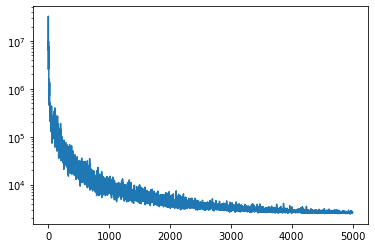

In [13]:
plt.plot(losses)
plt.yscale('log')

In [14]:
pred = pyro.infer.predictive.Predictive(pyro.poutine.uncondition(piecewise_regression),guide=piecewise_guide,num_samples=100)

fit = pred(x,y,n_knots)

fit_obs_mean = fit['obs'].mean(0).detach().numpy()
fit_obs_std = fit['obs'].std(0).detach().numpy()

<ErrorbarContainer object of 3 artists>

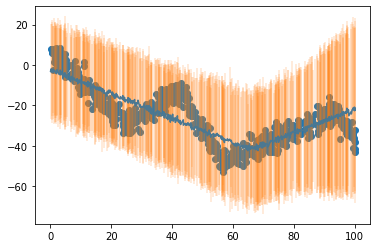

In [15]:
%matplotlib inline
plt.scatter(x,y)
plt.plot(x,fit_obs_mean)
plt.errorbar(x,fit_obs_mean,yerr=3*fit_obs_std,alpha=.2)

Now we'd like to evaluate the fit for each linear piece, and split the worst-fitting piece in two.

In [16]:
middle_knots = x.max()*fit['knot_x'].sort()[0]

In [17]:
first_piece = x < middle_knots

In [18]:
second_piece = x > middle_knots

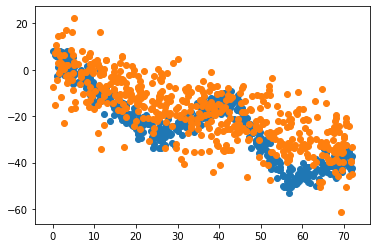

In [19]:
plt.scatter(x[first_piece[0]],y[first_piece[0]].detach().numpy())
plt.scatter(x[first_piece[0]],fit['obs'][0,first_piece[0]].detach().numpy())

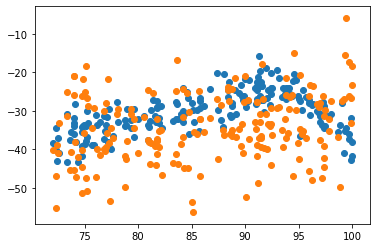

In [20]:
plt.scatter(x[second_piece[0]],y[second_piece[0]].detach().numpy())
plt.scatter(x[second_piece[0]],fit['obs'][0,second_piece[0]].detach().numpy())

In [21]:
Normal(fit['obs'][0,first_piece[0]],fit['y_scale'][0]).log_prob(y[first_piece[0]]).mean()

tensor(-4.2237, grad_fn=<MeanBackward0>)

In [22]:
Normal(fit['obs'][0,second_piece[0]],fit['y_scale'][0]).log_prob(y[second_piece[0]]).mean()

tensor(-3.8518, grad_fn=<MeanBackward0>)

We've identified the piece that fits the worst. Now we initialize a new instance of the model, with one more knot than before, in between the knots of the identified piece.

In [23]:
param_store_3 = pyro.get_param_store().get_state()

new_x_knot_loc = torch.cat([pyro.param('knot_x_loc')/2, pyro.param('knot_x_loc')])

new_x_knot_scale = torch.cat([pyro.param('knot_x_scale'), pyro.param('knot_x_scale')])

new_y_knot_loc = torch.cat([pyro.param('knot_y_loc')[:1], pyro.param('knot_y_loc')[:2].mean().unsqueeze(-1), pyro.param('knot_y_loc')[1:]])

new_y_knot_scale = torch.cat([pyro.param('knot_y_scale')[:1], 0.1*torch.ones(1), pyro.param('knot_y_scale')[1:]])

new_y_scale_loc = pyro.param('y_scale_loc')
new_y_scale_scale = pyro.param('y_scale_scale')

In [29]:
pyro.clear_param_store()

In [30]:
pyro.param('knot_x_loc', new_x_knot_loc.detach())
pyro.param('knot_x_scale', new_x_knot_scale.detach(), constraint = constraints.positive)
pyro.param('knot_y_loc', new_y_knot_loc.detach())
pyro.param('knot_y_scale', new_y_knot_scale.detach(), constraint = constraints.positive)
pyro.param('y_scale_loc', new_y_scale_loc.detach())
pyro.param('y_scale_scale', new_y_scale_scale.detach(), constraint = constraints.positive)

tensor([0.2193], grad_fn=<AddBackward0>)

In [31]:
dict(pyro.get_param_store())

{'knot_x_loc': tensor([0.3297, 0.6593], requires_grad=True),
 'knot_x_scale': tensor([0.0203, 0.0203], grad_fn=<AddBackward0>),
 'knot_y_loc': tensor([-0.0217, -0.2202, -0.4187, -0.2370], requires_grad=True),
 'knot_y_scale': tensor([0.0191, 0.1000, 0.0569, 0.1148], grad_fn=<AddBackward0>),
 'y_scale_loc': tensor([1.9738], requires_grad=True),
 'y_scale_scale': tensor([0.2193], grad_fn=<AddBackward0>)}

In [32]:
n_knots = 4

In [33]:
pred = pyro.infer.predictive.Predictive(pyro.poutine.uncondition(piecewise_regression),guide=piecewise_guide,num_samples=100)

fit = pred(x,y,n_knots)

fit_obs_mean = fit['obs'].mean(0).detach().numpy()
fit_obs_std = fit['obs'].std(0).detach().numpy()

<ErrorbarContainer object of 3 artists>

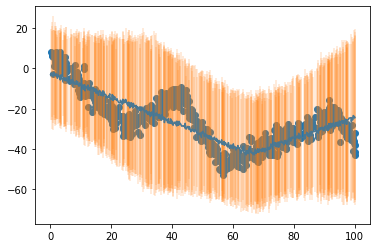

In [34]:
%matplotlib inline
plt.scatter(x,y)
plt.plot(x,fit_obs_mean)
plt.errorbar(x,fit_obs_mean,yerr=3*fit_obs_std,alpha=.2)

In [35]:
optim = pyro.optim.Adam({"lr": 0.05})
elbo = Trace_ELBO(num_particles=10, vectorize_particles=True,max_plate_nesting=1)
svi = SVI(piecewise_regression, piecewise_guide, optim, loss=elbo)

In [36]:
%%time
losses = []
for i in tqdm(range(5000)):
    losses.append(svi.step(x,y,n_knots))

100%|██████████| 5000/5000 [00:24<00:00, 203.03it/s]

CPU times: user 24.6 s, sys: 138 ms, total: 24.7 s
Wall time: 24.6 s


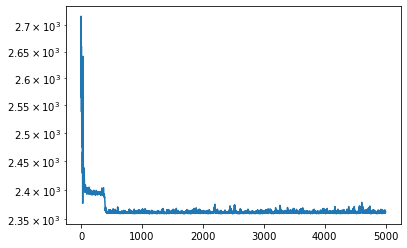

In [37]:
plt.plot(losses)
plt.yscale('log')

In [38]:
dict(pyro.get_param_store())

{'knot_x_loc': tensor([0.6449, 0.9420], requires_grad=True),
 'knot_x_scale': tensor([0.0075, 0.0072], grad_fn=<AddBackward0>),
 'knot_y_loc': tensor([-0.0159, -0.4314, -0.2470, -0.3557], requires_grad=True),
 'knot_y_scale': tensor([0.0052, 0.0049, 0.0072, 0.0148], grad_fn=<AddBackward0>),
 'y_scale_loc': tensor([1.9086], requires_grad=True),
 'y_scale_scale': tensor([0.0268], grad_fn=<AddBackward0>)}

In [39]:
pred = pyro.infer.predictive.Predictive(pyro.poutine.uncondition(piecewise_regression),guide=piecewise_guide,num_samples=100)

fit = pred(x,y,n_knots)

fit_obs_mean = fit['obs'].mean(0).detach().numpy()
fit_obs_std = fit['obs'].std(0).detach().numpy()

<ErrorbarContainer object of 3 artists>

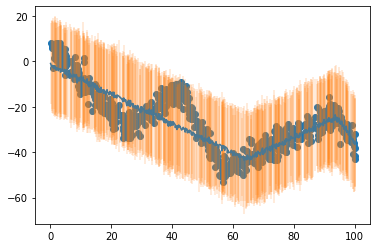

In [40]:
%matplotlib inline
plt.scatter(x,y)
plt.plot(x,fit_obs_mean)
plt.errorbar(x,fit_obs_mean,yerr=3*fit_obs_std,alpha=.2)

In [43]:
knots = x.max()*fit['knot_x'].sort()[0]

lb = torch.cat([torch.zeros(100,1), knots], dim=-1).unsqueeze(-1)
ub = torch.cat([knots, x.max()*torch.ones(100,1)], dim=-1).unsqueeze(-1)

x_less_than_lb = x.unsqueeze(-2) >= lb
x_greater_than_ub = x.unsqueeze(-2) <= ub

pieces_idx = x_less_than_lb*x_greater_than_ub

log_probs = Normal(fit['obs'], fit['y_scale'].unsqueeze(-1)).log_prob(y)

pieces_idx = pieces_idx.permute(-2,-3,-1)

logprobs = []
for i in range(knots.shape[1]+1):
    logprobs.append(log_probs[pieces_idx[i]].mean())

torch.argmin(torch.tensor(logprobs))

In [229]:
param_store_4 = pyro.get_param_store().get_state()

In [296]:
idx = 1

In [273]:
n_knots = pyro.param('knot_x_loc').shape[0] + 2
tmp = torch.zeros(n_knots)
tmp[1:-1] = pyro.param('knot_x_loc')
tmp[-1] = 1.

In [304]:
# split a piece in two
# new loc parameter of the x-coordinate is average of start- and end- knot
# same with scale paramater
# same with y_loc and and y_scale
new_x_knot_loc = torch.cat([pyro.param('knot_x_loc')[:idx], tmp[idx:idx+2].mean().unsqueeze(-1), pyro.param('knot_x_loc')[idx:]])
new_x_knot_scale = torch.cat([pyro.param('knot_x_scale')[:idx], pyro.param('knot_x_scale').mean().unsqueeze(-1), pyro.param('knot_x_scale')[idx:]])
new_y_knot_loc = torch.cat([pyro.param('knot_y_loc')[:idx+1], pyro.param('knot_y_loc')[idx:idx+2].mean().unsqueeze(-1), pyro.param('knot_y_loc')[idx+1:]])
new_y_knot_scale = torch.cat([pyro.param('knot_y_scale')[:idx+1], pyro.param('knot_y_scale')[idx:idx+2].mean().unsqueeze(-1), pyro.param('knot_y_scale')[idx+1:]])
# noise level is unchanged
new_y_scale_loc = pyro.param('y_scale_loc')
new_y_scale_scale = pyro.param('y_scale_scale')

In [305]:
pyro.clear_param_store()

In [306]:
pyro.param('knot_x_loc', new_x_knot_loc.detach())
pyro.param('knot_x_scale', new_x_knot_scale.detach(), constraint = constraints.positive)
pyro.param('knot_y_loc', new_y_knot_loc.detach())
pyro.param('knot_y_scale', new_y_knot_scale.detach(), constraint = constraints.positive)
pyro.param('y_scale_loc', new_y_scale_loc.detach())
pyro.param('y_scale_scale', new_y_scale_scale.detach(), constraint = constraints.positive)

tensor([0.0268], grad_fn=<AddBackward0>)

In [307]:
n_knots = 5

In [308]:
optim = pyro.optim.Adam({"lr": 0.05})
elbo = Trace_ELBO(num_particles=10, vectorize_particles=True,max_plate_nesting=1)
svi = SVI(piecewise_regression, piecewise_guide, optim, loss=elbo)

In [309]:
%%time
losses = []
for i in tqdm(range(5000)):
    losses.append(svi.step(x,y,n_knots))

100%|██████████| 5000/5000 [00:24<00:00, 200.35it/s]

CPU times: user 24.9 s, sys: 174 ms, total: 25 s
Wall time: 25 s


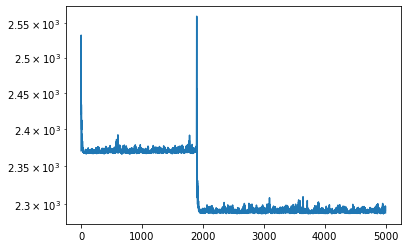

In [310]:
plt.plot(losses)
plt.yscale('log')

In [311]:
pred = pyro.infer.predictive.Predictive(pyro.poutine.uncondition(piecewise_regression),guide=piecewise_guide,num_samples=100)

fit = pred(x,y,n_knots)

fit_obs_mean = fit['obs'].mean(0).detach().numpy()
fit_obs_std = fit['obs'].std(0).detach().numpy()

<ErrorbarContainer object of 3 artists>

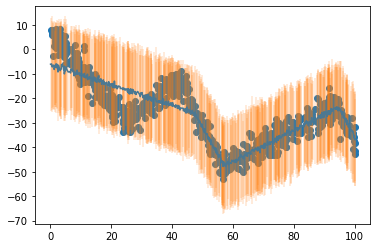

In [312]:
%matplotlib inline
plt.scatter(x,y)
plt.plot(x,fit_obs_mean)
plt.errorbar(x,fit_obs_mean,yerr=3*fit_obs_std,alpha=.2)

In [315]:
def worst_fitting_piece(fit):
    # get all sampled knots
    knots = x.max()*fit['knot_x'].sort()[0]

    # identify the indexes of x that make up the pieces
    lb = torch.cat([torch.zeros(100,1), knots], dim=-1).unsqueeze(-1)
    ub = torch.cat([knots, x.max()*torch.ones(100,1)], dim=-1).unsqueeze(-1)

    x_greater_than_lb = x.unsqueeze(-2) >= lb
    x_less_than_ub = x.unsqueeze(-2) <= ub

    pieces_idx = x_greater_than_lb*x_less_than_ub
    # compute log_prob of all data under current model
    log_probs = Normal(fit['obs'], fit['y_scale'].unsqueeze(-1)).log_prob(y)

    pieces_idx = pieces_idx.permute(-2,-3,-1)
    # average log_prob for each piece
    logprobs = []
    for i in range(knots.shape[1]+1):
        logprobs.append(log_probs[pieces_idx[i]].mean())
    # return idx of piece with lowest log_prob
    return torch.argmin(torch.tensor(logprobs))

In [319]:
worst_piece = worst_fitting_piece(fit)

In [317]:
param_store_5 = pyro.get_param_store().get_state()

In [318]:
def compute_split_params(idx):
    # split the idx'th piece in two
    n_knots = pyro.param('knot_x_loc').shape[0] + 2
    padded_knots = torch.zeros(n_knots)
    padded_knots[1:-1] = pyro.param('knot_x_loc')
    padded_knots[-1] = 1.
    # new loc parameter of the x-coordinate is average of start- and end- knot
    # same with scale paramater
    # same with y_loc and and y_scale
    new_x_knot_loc = torch.cat([pyro.param('knot_x_loc')[:idx], tmp[idx:idx+2].mean().unsqueeze(-1), pyro.param('knot_x_loc')[idx:]])
    new_x_knot_scale = torch.cat([pyro.param('knot_x_scale')[:idx], pyro.param('knot_x_scale').mean().unsqueeze(-1), pyro.param('knot_x_scale')[idx:]])
    new_y_knot_loc = torch.cat([pyro.param('knot_y_loc')[:idx+1], pyro.param('knot_y_loc')[idx:idx+2].mean().unsqueeze(-1), pyro.param('knot_y_loc')[idx+1:]])
    new_y_knot_scale = torch.cat([pyro.param('knot_y_scale')[:idx+1], pyro.param('knot_y_scale')[idx:idx+2].mean().unsqueeze(-1), pyro.param('knot_y_scale')[idx+1:]])
    # noise level is unchanged
    new_y_scale_loc = pyro.param('y_scale_loc')
    new_y_scale_scale = pyro.param('y_scale_scale')
    
    # clear param store and init new params
    pyro.clear_param_store()
    pyro.param('knot_x_loc', new_x_knot_loc.detach())
    pyro.param('knot_x_scale', new_x_knot_scale.detach(), constraint = constraints.positive)
    pyro.param('knot_y_loc', new_y_knot_loc.detach())
    pyro.param('knot_y_scale', new_y_knot_scale.detach(), constraint = constraints.positive)
    pyro.param('y_scale_loc', new_y_scale_loc.detach())
    pyro.param('y_scale_scale', new_y_scale_scale.detach(), constraint = constraints.positive)

In [321]:
compute_split_params(worst_piece)

In [322]:
optim = pyro.optim.Adam({"lr": 0.05})
elbo = Trace_ELBO(num_particles=10, vectorize_particles=True,max_plate_nesting=1)
svi = SVI(piecewise_regression, piecewise_guide, optim, loss=elbo)

In [325]:
n_knots = 6

In [326]:
%%time
losses = []
for i in tqdm(range(5000)):
    losses.append(svi.step(x,y,n_knots))

100%|██████████| 5000/5000 [00:28<00:00, 175.37it/s]

CPU times: user 1min 51s, sys: 568 ms, total: 1min 52s
Wall time: 28.5 s


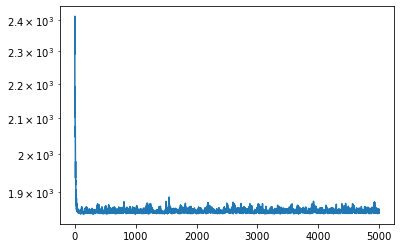

In [327]:
plt.plot(losses)
plt.yscale('log')

In [328]:
pred = pyro.infer.predictive.Predictive(pyro.poutine.uncondition(piecewise_regression),guide=piecewise_guide,num_samples=100)

fit = pred(x,y,n_knots)

fit_obs_mean = fit['obs'].mean(0).detach().numpy()
fit_obs_std = fit['obs'].std(0).detach().numpy()

<ErrorbarContainer object of 3 artists>

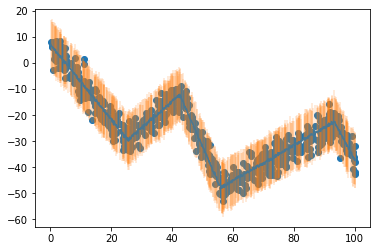

In [329]:
%matplotlib inline
plt.scatter(x,y)
plt.plot(x,fit_obs_mean)
plt.errorbar(x,fit_obs_mean,yerr=3*fit_obs_std,alpha=.2)